In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# Downloading data from Yahoo
'''
import yahoofinance as yf
symbol ='EUNL.DE'
hist = yf.HistoricalPrices(symbol,  '2010-10-31', '2020-11-11', frequency='1d')
hist.to_csv('C:/Users/MMD/PycharmProjects/Trading/Data Mining/Data/' + symbol + '.csv')
'''

"\nimport yahoofinance as yf\nsymbol ='EUNL.DE'\nhist = yf.HistoricalPrices(symbol,  '2010-10-31', '2020-11-11', frequency='1d')\nhist.to_csv('C:/Users/MMD/PycharmProjects/Trading/Data Mining/Data/' + symbol + '.csv')\n"

In [3]:
import datetime
import glob
import webbrowser
import os.path
import pandas as pd
import backtrader as bt
import backtrader.analyzers as btanal
import pyfolio as pf
import numpy as np
import sys
from scipy.stats import linregress
import quantstats as qs
import seaborn as sns
import optunity.metrics

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,13)

import warnings 
warnings.simplefilter(action='ignore', category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)

globalparams = dict(cash=10000,            
                    commission=0.005,
                    reserve=0.05,
                    )

c:\users\mmd\appdata\local\programs\python\python36\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
c:\users\mmd\appdata\local\programs\python\python36\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [62]:
import backtrader as bt
# <<<Function section>>>

# Momentum Function thanks to Teddy Koker https://teddykoker.com/2019/05/momentum-strategy-from-stocks-on-the-move-in-python/
def momentum_func(self, the_array):
    r = np.log(the_array)
    slope, _, rvalue, _, _ = linregress(np.arange(len(r)), r)
    annualized = (1 + slope) ** 252
    return annualized * (rvalue ** 2)

class Momentum(bt.ind.OperationN):
    lines = ('trend',)
    #params = dict(period=50)
    func = momentum_func

# Great Heatmap to analyse Output of opstrategy
def my_heatmap(data):
    data = np.array(data)
    xs = np.unique(data[:, 1].astype(int))
    ys = np.unique(data[:, 0].astype(int))
    print(xs, ys, data[:, 1].astype(int), data[:, 0].astype(int), data)
    vals = data[:, 3].reshape(len(ys), len(xs))
    min_val_ndx = np.unravel_index(np.argmin(vals, axis=None), vals.shape)
    max_val_ndx = np.unravel_index(np.argmax(vals, axis=None), vals.shape)

    cmap = LinearSegmentedColormap.from_list('', ['red', 'orange', 'yellow', 'chartreuse', 'limegreen'])
    ax = sns.heatmap(vals, xticklabels=xs, yticklabels=ys, cmap=cmap, annot=True, fmt='.2f')

    ax.add_patch(Rectangle(min_val_ndx[::-1], 1, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))
    ax.add_patch(Rectangle(max_val_ndx[::-1], 1, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))

    plt.tight_layout()
    plt.show()

def my_s
    
#Adapted Heatmap for Optunity output   
def my_heatmap_optunity(data):
    data = np.array(data)
    xs = np.unique(data[:, 1].astype(int))
    ys = np.unique(data[:, 0].astype(int))
    print(xs, ys, data[:, 1].astype(int), data[:, 0].astype(int), data)
    vals = data[:, 3].reshape(len(ys), len(xs))
    min_val_ndx = np.unravel_index(np.argmin(vals, axis=None), vals.shape)
    max_val_ndx = np.unravel_index(np.argmax(vals, axis=None), vals.shape)

    cmap = LinearSegmentedColormap.from_list('', ['red', 'orange', 'yellow', 'chartreuse', 'limegreen'])
    ax = sns.heatmap(vals, xticklabels=xs, yticklabels=ys, cmap=cmap, annot=True, fmt='.2f')

    ax.add_patch(Rectangle(min_val_ndx[::-1], 1, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))
    ax.add_patch(Rectangle(max_val_ndx[::-1], 1, 1, fill=False, edgecolor='blue', lw=3, clip_on=False))

    plt.tight_layout()
    plt.show()    
    
class CashMarket(bt.analyzers.Analyzer):
    """
    Analyzer returning cash and market values
    Thanks to run-out https://community.backtrader.com/post/11669
    """
    def create_analysis(self):
        self.rets = {}
        self.vals = 0.0

    def notify_cashvalue(self, cash, value):
        self.vals = (cash, value)
        self.rets[self.strategy.datetime.datetime().strftime("%Y-%m-%d")] = self.vals

    def get_analysis(self):
        return self.rets

In [63]:
# <<<Benchmark Strategy section>>>  
# Non-survivorship bias Benchmark Strategy
class HSt(bt.Strategy):
    """
    HoldAll Strategy.
    Usually, used for benchmarking test.
    Almost same with the HoldStrategy, it tries to buy all provided securities with the same ratio.
    buy_date: iso-format str, buy order will be created the first market day after the buy_date.
    https://github.com/samuel281/qu-ant/blob/master/lib/strategies/hold_all_strategy.py
    """
    params = dict(
        buy_date=datetime.datetime.today().isoformat(),
    )
    
    def __init__(self):
        self.stocks = self.datas[2:] #must filter out bond and spy 
                  
    def next(self):
        for d in self.stocks:
            if self.getposition(data=d).size:
                return
        
        if self.data.datetime.date(0).isoformat() < self.params.buy_date.isoformat(): #buydate must be determined by the first strategy, since it is the date of the first trade?
            return

        target_ratio = 1.0 - globalparams["reserve"]
        target_ratio_per_sec = target_ratio / len(self.stocks)            
        for d in self.stocks:
            self.order_target_percent(data=d, target=target_ratio_per_sec)            
    
    def log(self, arg):
        print('{} {}'.format(self.datetime.date(), arg))            
            
    def on_order_executed(self, order):
        pass
    
    '''
    def notify_order(self, order):
        if order.status in [order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        if order.status in [order.Submitted]:
            if order.isbuy():

                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} {} Price {:.2f} Value {:.2f} Size {} Cash {:.2f} Broker {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price , order.created.size, self.broker.getcash(), self.broker.getvalue()))
            if order.issell():
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} {} Price {:.2f} Value {:.2f} Size {} Broker {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price, order.created.size, self.broker.getvalue()))

            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))

            if order.issell():# Sell
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
    '''   

In [6]:
# Survivorship bias Benchmark Strategy (currently not working)
class HoldAllStrategy(bt.Strategy):
    """
    HoldAll Strategy.
    Usually, used for benchmarking test.
    Almost same with the HoldStrategy, it tries to buy all provided securities with the same ratio.
    buy_date: iso-format str, buy order will be created the first market day after the buy_date.
    https://github.com/samuel281/qu-ant/blob/master/lib/strategies/hold_all_strategy.py
    """
    params = dict(
        buy_date=datetime.datetime.today().isoformat(),
    )
    
    def __init__(self):
        self.stocks = [i for i in self.getdatanames()] #must filter out bond and spy
        for d in self.stocks:
            self.dnames[d].lengthlist = [0]
        

    def prenext(self):
        '''
        if self.position:
            return
        '''
        if self.data.datetime.date(0).isoformat() < self.params.buy_date.isoformat(): #buydate must be determined by the first strategy, since it is the date of the first trade?
            return
        self.member = []
        self.member_sell = []

        for d in self.stocks:
            datad = self.dnames[d]
            datad.lengthlist.append(len(datad))
            posdata = [d for d, pos in self.getpositions().items() if pos]
            #print(len(datad))
            if len(datad) > 0:
                if datad.lengthlist[-1] > datad.lengthlist[-2]:  
                    self.member.append(d)
                    print(self.data.datetime.date(0).isoformat(), datad.lengthlist[-1], datad.lengthlist[-2])
                elif d in posdata and datad.lengthlist[-1] == datad.lengthlist[-2]:
                    self.member_sell.append(d)
                    print(d)
                    
    def nextstart(self):
        # This is called exactly ONCE, when next is 1st called and defaults to
        # call `next`
        self.member = []
        self.member_sell = []
        self.next()  # delegate the work to next
        
    def next(self):
        target_ratio = 1.0 - globalparams["reserve"]
        target_ratio_per_sec = target_ratio / len(self.member)
            
        posdata = [d for d, pos in self.getpositions().items() if pos]
        for d in self.member:
            if d in self.member and not d in posdata:
                self.order_target_percent(data=self.getdatabyname(d), target=target_ratio_per_sec)
        for d in self.member_sell:
            self.order_target_percent(data=self.getdatabyname(d), target=0.0)
            
    
    def log(self, arg):
        print('{} {}'.format(self.datetime.date(), arg))            
            
    def on_order_executed(self, order):
        pass

    def notify_order(self, order):
        if order.status in [order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        if order.status in [order.Submitted]:
            if order.isbuy():

                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} {} Price {:.2f} Value {:.2f} Size {} Cash {:.2f} Broker {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price , order.created.size, self.broker.getcash(), self.broker.getvalue()))
            if order.issell():
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} {} Price {:.2f} Value {:.2f} Size {} Broker {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price, order.created.size, self.broker.getvalue()))

            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))

            if order.issell():# Sell
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

2015-08-31 Enter ARKK - Rank 5.59
2015-08-31 Enter ARKW - Rank 3.77
2015-09-30 Leave ARKK - Rank 15.02
2015-09-30 Rebal ARKW - Rank 15.18
2015-09-30 Enter QQQ - Rank 17.41
2015-10-30 Leave ARKW - Rank 110.15
2015-10-30 Rebal QQQ - Rank 347.20
2015-10-30 Enter EUNL.DE - Rank 333.88
2015-11-30 Leave QQQ - Rank 53.39
2015-11-30 Rebal EUNL.DE - Rank 137.96
2015-11-30 Enter ARKW - Rank 139.38
2015-12-31 Rebal ARKW - Rank 5.47
2015-12-31 Rebal EUNL.DE - Rank 28.17
2016-01-29 Leave ARKW - Rank 2.98
2016-01-29 Leave EUNL.DE - Rank 0.80
2016-01-29 Enter ARKK - Rank 6.43
2016-01-29 Enter QQQ - Rank 4.23
2016-02-29 Leave QQQ - Rank 253.60
2016-02-29 Rebal ARKK - Rank 875.57
2016-02-29 Enter ARKW - Rank 1086.29
2016-03-31 Leave ARKK - Rank 115.30
2016-03-31 Rebal ARKW - Rank 146.74
2016-03-31 Enter QQQ - Rank 190.02
2016-04-29 Leave ARKW - Rank 19.47
2016-04-29 Rebal QQQ - Rank 43.46
2016-04-29 Enter EUNL.DE - Rank 29.06
2016-05-31 Leave QQQ - Rank 135.26
2016-05-31 Rebal EUNL.DE - Rank 231.74
201

2020-06-18 Leave ARKK - Rank 5.88
2020-06-18 Leave EUNL.DE - Rank 0.01
2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Rebal QQQ - Rank 42.31
2016-08-31 Leave ARKK - Rank 49.10
2016-08-31 Leave EUNL.DE - Rank 6.58
2016-08-31 Rebal ARKW - Rank 81.54
2016-08-31 Rebal QQQ - Rank 178.14
2020-06-18 Leave ARKK - Rank 5.88
2020-06-18 Leave EUNL.DE - Rank 0.01
2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Rebal QQQ - Rank 42.31
2016-09-30 Leave QQQ - Rank 139.60
2016-09-30 Leave EUNL.DE - Rank 140.11
2016-09-30 Rebal ARKW - Rank 350.71
2016-09-30 Rebal ARKK - Rank 275.48
2020-06-18 Leave EUNL.DE - Rank 0.01
2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Enter QQQ - Rank 42.31
2016-10-31 Leave ARKW - Rank 1.91
2016-10-31 Rebal EUNL.DE - Rank 131.85
2016-10-31 Enter ARKK - Rank 40.62
2020-06-18 Leave ARKK - Rank 5.88
2020-06-18 Leave EUNL.DE - Rank 0.01
2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Rebal QQQ - Rank 42.31
2016-11-30 Leave QQQ - Rank 114.60
2016-11-30 Leave ARKK - Rank 10.84
2016-11-

2020-06-18 Leave ARKK - Rank 5.88
2020-06-18 Leave EUNL.DE - Rank 0.01
2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Rebal QQQ - Rank 42.31
2019-09-30 Leave ARKW - Rank 16.98
2019-09-30 Leave ARKK - Rank 20.96
2019-09-30 Rebal QQQ - Rank 47.52
2019-09-30 Rebal EUNL.DE - Rank 92.40
2020-06-18 Leave ARKK - Rank 5.88
2020-06-18 Rebal QQQ - Rank 42.31
2020-06-18 Enter ARKW - Rank 81.49
2019-10-31 Leave ARKK - Rank 88.09
2019-10-31 Rebal QQQ - Rank 174.50
2019-10-31 Enter EUNL.DE - Rank 194.16
2020-06-18 Leave ARKK - Rank 5.88
2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Rebal QQQ - Rank 42.31
2019-11-29 Leave QQQ - Rank 190.99
2019-11-29 Rebal ARKW - Rank 453.31
2019-11-29 Rebal ARKK - Rank 572.59
2020-06-18 Leave ARKK - Rank 5.88
2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Enter QQQ - Rank 42.31
2019-12-31 Leave ARKW - Rank 225.25
2019-12-31 Leave ARKK - Rank 60.94
2019-12-31 Enter QQQ - Rank 426.37
2019-12-31 Enter EUNL.DE - Rank 347.19
2020-06-18 Leave ARKK - Rank 5.88
2020-06-18 Lea

2020-06-18 Leave ARKK - Rank 5.88
2020-06-18 Leave EUNL.DE - Rank 0.01
2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Rebal QQQ - Rank 42.31
2020-06-18 Leave ARKK - Rank 5.79
2020-06-18 Leave EUNL.DE - Rank 0.01
2020-06-18 Rebal ARKW - Rank 80.43
2020-06-18 Rebal QQQ - Rank 43.68
2017-05-31 Leave QQQ - Rank 72.62
2017-05-31 Leave EUNL.DE - Rank 98.39
2017-05-31 Rebal ARKW - Rank 345.46
2017-05-31 Rebal ARKK - Rank 171.30
2020-06-18 Leave ARKK - Rank 5.88
2020-06-18 Leave EUNL.DE - Rank 0.01
2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Rebal QQQ - Rank 42.31
2020-06-18 Leave ARKK - Rank 5.79
2020-06-18 Leave EUNL.DE - Rank 0.01
2020-06-18 Rebal ARKW - Rank 80.43
2020-06-18 Rebal QQQ - Rank 43.68
2017-06-30 Leave ARKW - Rank 20.03
2017-06-30 Leave QQQ - Rank 6.38
2017-06-30 Rebal ARKK - Rank 45.38
2017-06-30 Rebal EUNL.DE - Rank 46.85
2020-06-18 Leave ARKK - Rank 5.88
2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Rebal QQQ - Rank 42.31
2020-06-18 Leave ARKK - Rank 5.79
2020-06-18 Rebal A

2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Rebal QQQ - Rank 42.31
2020-06-18 Rebal ARKW - Rank 80.43
2020-06-18 Rebal QQQ - Rank 43.68
2019-06-28 Leave ARKW - Rank 107.02
2019-06-28 Rebal QQQ - Rank 117.21
2019-06-28 Enter ARKK - Rank 129.38
2020-06-18 Leave ARKK - Rank 5.88
2020-06-18 Rebal QQQ - Rank 42.31
2020-06-18 Enter ARKW - Rank 81.49
2020-06-18 Leave ARKK - Rank 5.79
2020-06-18 Rebal QQQ - Rank 43.68
2020-06-18 Enter ARKW - Rank 80.43
2019-07-31 Leave QQQ - Rank 6.36
2019-07-31 Rebal ARKK - Rank 15.26
2019-07-31 Enter EUNL.DE - Rank 131.32
2020-06-18 Leave ARKK - Rank 5.88
2020-06-18 Leave EUNL.DE - Rank 0.01
2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Rebal QQQ - Rank 42.31
2020-06-18 Leave ARKK - Rank 5.79
2020-06-18 Leave EUNL.DE - Rank 0.01
2020-06-18 Rebal ARKW - Rank 80.43
2020-06-18 Rebal QQQ - Rank 43.68
2019-08-30 Leave ARKW - Rank 0.87
2019-08-30 Leave QQQ - Rank 1.19
2019-08-30 Rebal ARKK - Rank 6.45
2019-08-30 Rebal EUNL.DE - Rank 55.75
2020-06-18 Leave ARKK -

2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Rebal QQQ - Rank 42.31
2020-06-18 Rebal ARKW - Rank 80.43
2020-06-18 Rebal QQQ - Rank 43.68
2020-06-18 Rebal ARKW - Rank 108.90
2020-06-18 Rebal QQQ - Rank 57.53
2016-09-30 Leave QQQ - Rank 165.53
2016-09-30 Rebal ARKW - Rank 279.25
2016-09-30 Enter ARKK - Rank 248.61
2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Rebal QQQ - Rank 42.31
2020-06-18 Rebal ARKW - Rank 80.43
2020-06-18 Rebal QQQ - Rank 43.68
2020-06-18 Rebal ARKW - Rank 108.90
2020-06-18 Rebal QQQ - Rank 57.53
2016-10-31 Leave ARKW - Rank 3.61
2016-10-31 Leave QQQ - Rank 0.58
2016-10-31 Enter EUNL.DE - Rank 127.37
2016-10-31 Enter ARKK - Rank 30.96
2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Rebal QQQ - Rank 42.31
2020-06-18 Rebal ARKW - Rank 80.43
2020-06-18 Rebal QQQ - Rank 43.68
2020-06-18 Rebal ARKW - Rank 108.90
2020-06-18 Rebal QQQ - Rank 57.53
2016-11-30 Leave QQQ - Rank 95.43
2016-11-30 Rebal ARKW - Rank 150.21
2016-11-30 Enter EUNL.DE - Rank 775.91
2020-06-18 Leave EU

2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Rebal QQQ - Rank 42.31
2020-06-18 Rebal ARKW - Rank 80.43
2020-06-18 Rebal QQQ - Rank 43.68
2020-06-18 Rebal ARKW - Rank 108.90
2020-06-18 Rebal QQQ - Rank 57.53
2018-09-28 Leave ARKW - Rank 0.89
2018-09-28 Rebal QQQ - Rank 116.39
2018-09-28 Enter EUNL.DE - Rank 298.89
2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Rebal QQQ - Rank 42.31
2020-06-18 Rebal ARKW - Rank 80.43
2020-06-18 Rebal QQQ - Rank 43.68
2020-06-18 Rebal ARKW - Rank 108.90
2020-06-18 Rebal QQQ - Rank 57.53
2018-10-31 Leave ARKW - Rank 0.44
2018-10-31 Rebal QQQ - Rank 7.33
2018-10-31 Enter EUNL.DE - Rank 23.26
2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Rebal QQQ - Rank 42.31
2020-06-18 Rebal ARKW - Rank 80.43
2020-06-18 Rebal QQQ - Rank 43.68
2020-06-18 Rebal ARKW - Rank 108.90
2020-06-18 Rebal QQQ - Rank 57.53
2018-11-30 Leave ARKW - Rank 0.47
2018-11-30 Rebal QQQ - Rank 3.83
2018-11-30 Enter EUNL.DE - Rank 14.54
2020-06-18 Rebal ARKW - Rank 81.49
2020-06-18 Rebal QQQ - 

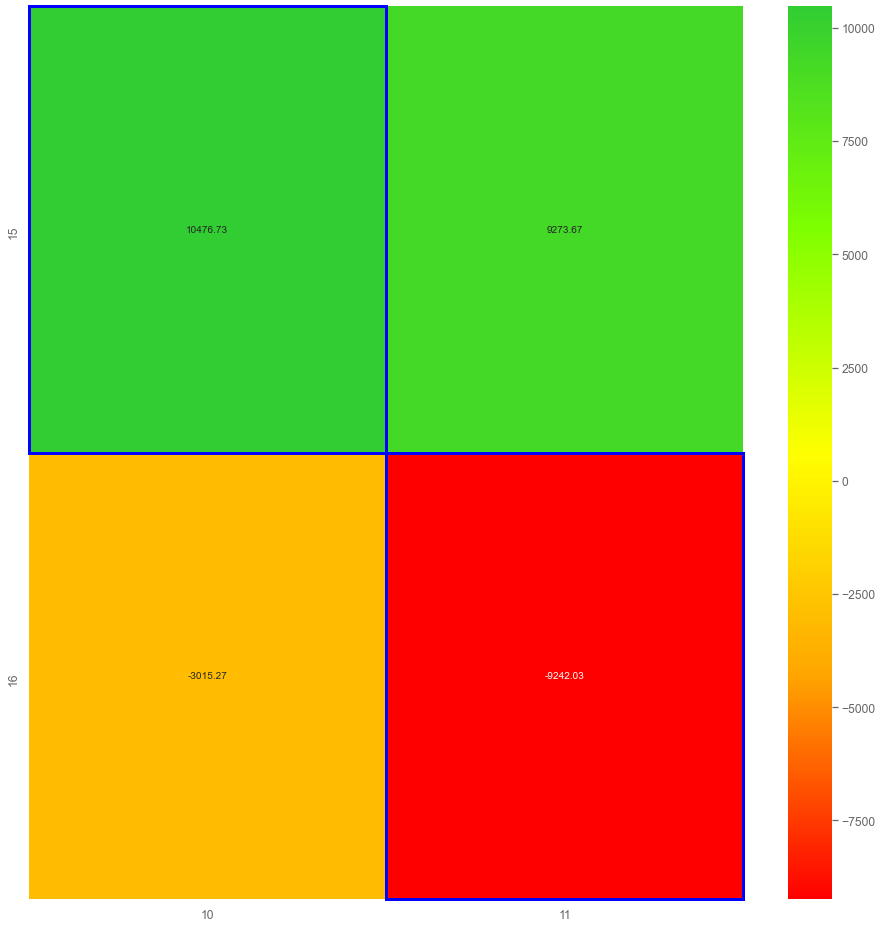

Profit ... or Loss: -45384.13


In [64]:
# <<<Momentum Strategy section>>>
class St(bt.Strategy):
    params = dict(
        selcperc=0.50,  # percentage of stocks to select from the universe
        rperiod=1,  # period for the returns calculation, default 1 period
        vperiod=11,  # lookback period for volatility - default 36 periods
        mperiod=16,  # lookback period for momentum - default 90 periods
        momentum=Momentum, # parametrize the momentum and its period
        reserve=globalparams["reserve"],  # 5% reserve capital
        monthdays=[1],
        monthcarry=True,
        when=bt.timer.SESSION_START,
        benchmarkstop=False, # If true, no stocks will be bought and no rebalancing will be done if benchmark is below SMAperiod
        SMAperiod=200,
        benchmark_bond=True, # Sell all Stocks and buy Bonds
        jump_momentum=True, # If true, after a time of jump_one (30 days x jump_one) in every month, all the money will be directed to the best performing stock. Rule for that:
                            # In Excel, this is a 0.6 x month return of fund with best past 3 month return plus 0.4 x return of fund with best return, month to date.
        jump_one=0.6,
        printlog=True,
    )

    def __init__(self):
        self.bench = self.data0
        self.bond = self.data1
        self.stocks = self.datas[2:]
        # calculate 1st the amount of stocks that will be selected
        self.selnum = int(len(self.stocks) * self.p.selcperc)

        # allocation perc per stock
        # reserve kept to make sure orders are not rejected due to
        # margin. Prices are calculated when known (close), but orders can only
        # be executed next day (opening price). Price can gap upwards
        self.perctarget = (1.0 - self.p.reserve) / self.selnum
        
        # This is the set up of the timer that makes the strategy being executed at the given time
        self.add_timer(
            when=self.p.when,
            monthdays=self.p.monthdays,
            monthcarry=self.p.monthcarry
        )
        
        jump = True

        # returns, volatilities and momentums
        rs = [bt.ind.PctChange(d, period=self.p.rperiod) for d in self.stocks]
        vs = [bt.ind.StdDev(ret, period=self.p.vperiod) for ret in rs]
        #ms = [bt.ind.ROC(d, period=self.p.mperiod) for d in self.datas]
        ms = [self.p.momentum(d, period=self.p.mperiod) for d in self.stocks]
        
        self.bench_sma = bt.ind.SMA(self.data0, period=self.p.SMAperiod)
        
        # simple rank formula: (momentum * net payout) / volatility
        # the highest ranked: low vol, large momentum, large payout
        self.ranks = {d: m / v for d, v, m in zip(self.stocks, vs, ms)}
        #TODO: does it perform better without the volatility?

        self.bench_filter = self.bench < self.bench_sma
        
    def prenext(self):
        # call next() even when data is not available for all tickers
        self.next()     


    def log(self, arg):
        if self.p.printlog:
            print('{} {}'.format(self.datetime.date(), arg))
        
    # This section is for logging of orders in greater detail to figure out whether the strategy is actually having no problem with orders
    '''
    def notify_order(self, order):
        if order.status in [order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        if order.status in [order.Submitted]:
            if order.isbuy():
            
                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} {} Price {:.2f} Value {:.2f} Size {} Cash {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price , order.created.size, self.broker.getcash()))
            if order.issell():
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price, order.created.size))

            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))

            if order.issell():# Sell
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))


        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
    '''       
    
    # This is the function using the timer to execute the rebalance 
    def notify_timer(self, timer, when, *args, **kwargs):
        #print('strategy notify_timer with tid {}, when {} _getminperstatus {}'.
        #      format(timer.p.tid, when, int(self._getminperstatus())))
        if self._getminperstatus() < 0:
            self.rebalance()
  
    def next(self):
        pass # must be filled with a pass

    
    # Actual order giving by a ranking takes place here
    def rebalance(self):
        
        #if jump == True:
        # Enter Jump Code here    
        
        # sort data and current rank
        ranks = sorted(
            self.ranks.items(),  # get the (d, rank), pair
            key=lambda x: x[1][0],  # use rank (elem 1) and current time "0"
            reverse=True,  # highest ranked 1st ... please
        )
        
        # put top ranked in dict with data as key to test for presence
        rtop = dict(ranks[:self.selnum])

        # For logging purposes of stocks leaving the portfolio
        rbot = dict(ranks[self.selnum:])

        # prepare quick lookup list of stocks currently holding a position
        posdata = [d for d, pos in self.getpositions().items() if pos]
        

        if self.p.benchmarkstop:
            for d in (d for d in posdata):
                if "Bond" == d._name and self.bench_filter:
                    return
                else:
                    if "Bond" == d._name and not self.bench_filter:
                        self.order_target_percent("Bond", target=0.0)
                        self.log('Leave {} due to end of down period'.format(d._name))
                        return
            
        # Triple Momentum: If Benchmark index is below SMA, nothing will be bought or rebalanced
        if self.p.benchmarkstop:
            if self.bench_filter:
                #print('SMA {} - Bench {}'.format(self.bench_sma[0], self.bench[0]))
                if self.p.benchmark_bond:
                    for d in posdata:
                        self.log('Leave {} due to switch to Bonds'.format(d._name))
                        self.order_target_percent(d, target=0.0)
                    self.order_target_percent("Bond", target=0.95)
                    self.log('Buy Bond')
                    bond_flag = True
                    return #Code stops here and skips rebalancing und buying
                
        # remove those no longer top ranked
        # do this first to issue sell orders and free cash
        for d in (d for d in posdata if d not in rtop):
            self.log('Leave {} - Rank {:.2f}'.format(d._name, rbot[d][0]))
            self.order_target_percent(d, target=0.0)
        
        # rebalance those already top ranked and still there
        for d in (d for d in posdata if d in rtop):
            self.log('Rebal {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            self.order_target_percent(d, target=self.perctarget)
            del rtop[d]  # remove it, to simplify next iteration

        # issue a target order for the newly top ranked stocks
        # do this last, as this will generate buy orders consuming cash
        for d in rtop:
            self.log('Enter {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            self.order_target_percent(d, target=self.perctarget)
            
    def stop(self):
        pnl = round(self.broker.getvalue() - globalparams["cash"],2)
        print('Final PnL: {}'.format(
            pnl))


def run(args=None):
    #optreturn=False otherwise the heatmap doesn't work
    cerebro = bt.Cerebro(maxcpus=1,
                         preload=False,
		                 optdatas=False,
		                 optreturn=False,
		                 stdstats=True) 

    
# <<<Data loading section>>>
    
    # Parse from/to-date
    fromdate = datetime.datetime(2014, 11, 3)
    todate = datetime.datetime(2020, 6, 18)
    
    # Add SPY/QQQ as "Benchmark"
    df0 = pd.read_csv(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\QQQ.csv', index_col=0, parse_dates=True)
    benchdata = bt.feeds.PandasData(dataname=df0,name="QQQ",fromdate=fromdate, todate=todate,  plot=False)
    cerebro.adddata(benchdata)

    # Add TMF as "Bond"
    df1 = pd.read_csv(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\TMF.csv', index_col=0, parse_dates=True)
    bonddata = bt.feeds.PandasData(dataname=df1,name="Bond",fromdate=fromdate, todate=todate, plot=False)
    cerebro.adddata(bonddata)    
    
    # add all the data files available in the directory datadir
    for fname in glob.glob(os.path.join(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\Momentum', '*')):
        df = pd.read_csv(fname, index_col=0, parse_dates=True)

        if len(df)>200:
            cerebro.adddata(bt.feeds.PandasData(dataname=df,name=os.path.basename(fname).replace(".csv", ""),fromdate=fromdate, todate=todate, plot=False))
            #print(os.path.basename(fname).replace(".csv", "")) #prints the name of the added csv file
            
            
# <<<Cerebro loading section>>>


    # Optimization by Optunity (usually partical swarm if i remember correctly)
    def runstrat(p1, p2):
        print(int(p1),int(p2))
        cerebro = bt.Cerebro(maxcpus=0,stdstats=True)
        cerebro.addstrategy(St, mperiod=int(p1), vperiod=int(p2),printlog=False) #
        cerebro.broker.setcash(globalparams["cash"])
        cerebro.broker.setcommission(commission=globalparams["commission"])
        cerebro.adddata(benchdata)
        cerebro.adddata(bonddata)  
        for fname in glob.glob(os.path.join(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\Momentum', '*')):
            df = pd.read_csv(fname, index_col=0, parse_dates=True)
            if len(df)>200:
                cerebro.adddata(bt.feeds.PandasData(dataname=df,name=os.path.basename(fname).replace(".csv", ""),fromdate=fromdate, todate=todate, plot=False))        
        
        cerebro.broker.set_coc(True)
        cerebro.run(maxcpus=0)
        return cerebro.broker.getvalue() #can be switched to whatever should be maximized/minimized
   

    opt = optunity.maximize(runstrat, num_evals=4, p1 = [1, 300], p2=[2, 50])
    
    optimal_pars, details, _ = opt
    print('Optimal Parameters:')
    print('maperiod1 = %.4f' % optimal_pars['p1'])
    print('maperiod2 = %.4f' % optimal_pars['p2'])

    final_results_list = []
    for i in range(0, len(details[2]['args']['p1'])):
        PnL = round(details[2]['values'][i] - globalparams["cash"], 2)
        p1 = int(details[2]['args']['p1'][i])
        p2 =int(details[2]['args']['p2'][i])
        final_results_list.append([p1, p2, PnL, PnL])
        print(type(PnL), type(p1))
        #final_results_list.append([strategy.params.mperiod, strategy.params.vperiod, PnL, round(average_annual_return*100, 2)]) # Adjust here the Heatmap variables params y-axis and x-axis #2
    print(final_results_list)
    my_heatmap_optunity(final_results_list)
  


    # add strategy
    #cerebro.addstrategy(HoldAllStrategy, buy_date=datetime.date(2013, 3, 31))
    #cerebro.addstrategy(HSt, buy_date=datetime.date(2014, 11, 3))
    #cerebro.addstrategy(St, mperiod=int(optimal_pars['p1']), vperiod=int(optimal_pars['p2']))

    #cerebro.optstrategy(St, mperiod=range(15, 17), vperiod=range(10, 12))
    

   
    # set the cash, cheat on close and commission
    cerebro.broker.setcash(globalparams["cash"])
    cerebro.broker.set_coc(True)
    cerebro.broker.setcommission(commission=globalparams["commission"])
    
    # Adding Analysers
    #cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')
    cerebro.addanalyzer(CashMarket, _name='cashmarket')
    '''
    cerebro.addanalyzer(btanal.PyFolio)                # Needed to use PyFolio
    cerebro.addanalyzer(btanal.TradeAnalyzer)          # Analyzes individual trades
    
    
    
    # If you want to have all data written into a log file
    #cerebro.addwriter(bt.WriterFile, csv=True, out='log.csv')
    
    cerebro.addobserver(bt.observers.Benchmark,
                        data=benchdata,
                        timeframe=bt.TimeFrame.NoTimeFrame)
    '''
    results = cerebro.run(maxcpus=1)#maxcpu=1 otherwise pickling multiprocessing errors
    
    # Heatmap with opstrategy (which doesn't work at the moment...)
    '''
    final_results_list = []
    for run in results:
        for strategy in run:
            my_dict = strategy.analyzers.cashmarket.get_analysis()
            my_di = list(my_dict.items())
            #annual_returns = [v for _, v in my_dict.items() if v != 0]
            #average_annual_return = sum(annual_returns) / len(annual_returns)
            PnL = round(my_di[-1][1][1]+my_di[-1][1][0] - globalparams["cash"], 2)
            print(type(PnL), type(strategy.params.vperiod))
            final_results_list.append([strategy.params.mperiod, strategy.params.vperiod, PnL, round(PnL, 2)])
            #final_results_list.append([strategy.params.mperiod, strategy.params.vperiod, PnL, round(average_annual_return*100, 2)]) # Adjust here the Heatmap variables params y-axis and x-axis #2
    print(final_results_list)
    my_heatmap(final_results_list)
    '''
    
# <<<Performance analysing section section>>>

    #cerebro.plot()

    # Basic performance evaluation ... final value ... minus starting cash
    pnl = cerebro.broker.get_value() - globalparams["cash"]
    print('Profit ... or Loss: {:.2f}'.format(pnl))
    
    # Quantstats thanks to https://algotrading101.com/learn/backtrader-for-backtesting/
    # Does not work with optstrategy
    '''
    returns, positions, transactions, gross_lev = results[0].analyzers.pyfolio.get_pf_items()
    returns.index = returns.index.tz_convert(None)
    qs.reports.html(returns, output='stats.html', title='Momentum')
    webbrowser.open('stats.html')
    '''
    
    # Pyfolio if needed
    '''
    returns, positions, transactions, gross_lev = results[0].analyzers.pyfolio.get_pf_items()
    benchmark_rets = pd.Series([0.00004] * len(returns.index), index=returns.index)     
    pf.create_full_tear_sheet(returns, positions, transactions, benchmark_rets=benchmark_rets)
    '''
    
# <<<Execute starting section>>>    
if __name__ == '__main__':
    run()